### Basic imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-darkgrid")

In [2]:
df = pd.read_excel('News Title.xls', index='No')
df.head()

,No,News Title,Category
0,1,Google+ rolls out 'Stories' for tricked out ph...,Technology
1,2,Dov Charney's Redeeming Quality,Business
2,3,White God adds Un Certain Regard to the Palm Dog,Entertainment
3,4,"Google shows off Androids for wearables, cars,...",Technology
4,5,China May new bank loans at 870.8 bln yuan,Business


In [3]:
df = df.drop('No', axis=1)

## EDA

### Finding null rows

In [4]:
df.isnull().sum()

News Title    0
Category      0
dtype: int64

In [5]:
df['Category'].value_counts()

Entertainment    23961
Business         17707
Technology       16776
Medical           7091
Name: Category, dtype: int64

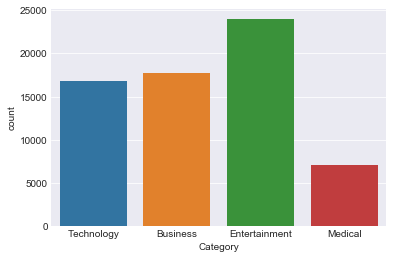

In [6]:
sns.countplot(df['Category'])

#### Here, we can see that the data is imbalanced. What we can do is randomly select the sum of the minimal label (7091).

In [7]:
num_of_categories = 7091
shuffled = df.reindex(np.random.permutation(df.index))
e = shuffled[shuffled['Category'] == 'Entertainment'][:num_of_categories]
b = shuffled[shuffled['Category'] == 'Business'][:num_of_categories]
t = shuffled[shuffled['Category'] == 'Technology'][:num_of_categories]
m = shuffled[shuffled['Category'] == 'Medical'][:num_of_categories]
new_df = pd.concat([e,b,t,m], ignore_index=True)

new_df = new_df.reindex(np.random.permutation(df.index))
new_df['Label'] = 0

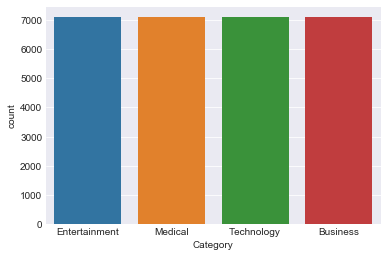

In [8]:
sns.countplot(new_df['Category'])

In [9]:
new_df.dropna(inplace=True)

In [10]:
new_df['Length'] = new_df['News Title'].apply(len)

In [11]:
new_df.sort_values('Length',ascending=False)

,News Title,Category,Label,Length
2650,"Movie review: 'Edge of Tomorrow' a fun, furiou...",Entertainment,0,91
28041,Oscar Pistorius trial restart could be delayed...,Medical,0,91
3634,Rolf Harris trial: Entertainer could be stripp...,Entertainment,0,90
5938,Box office report: 'X-Men: Days of Future Past...,Entertainment,0,90
14680,First living thing with 'alien' DNA created in...,Technology,0,90
...,...,...,...,...
3557,Sabotage,Entertainment,0,8
18657,Stork 2,Technology,0,7
7502,Subway,Business,0,6
3786,Tammy,Entertainment,0,5


In [12]:
# sometimes due to the random data selection on our previous steps, we may get some outlier lengths.
new_df = new_df[new_df['Length'] <= 100]

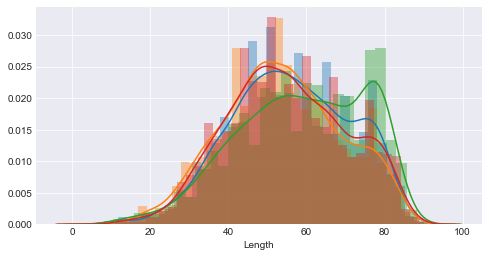

In [13]:
plt.figure(figsize=(8,4))
sns.distplot(new_df[new_df['Category'] == 'Technology']['Length'])
sns.distplot(new_df[new_df['Category'] == 'Business']['Length'])
sns.distplot(new_df[new_df['Category'] == 'Entertainment']['Length'])
sns.distplot(new_df[new_df['Category'] == 'Medical']['Length'])

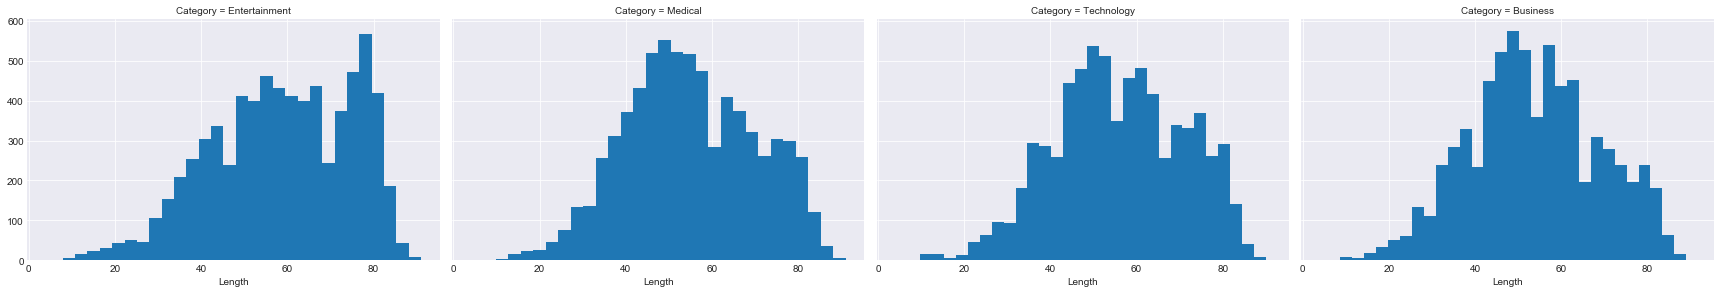

In [14]:
g = sns.FacetGrid(new_df, col="Category", height=4, aspect=1.5)
g.map_dataframe(plt.hist, x="Length", bins=30)
g.set_axis_labels("Length")

In [15]:
new_df.groupby('Category').mean()['Length']

Category
Business         53.710760
Entertainment    58.779862
Medical          54.947821
Technology       55.985051
Name: Length, dtype: float64

In [16]:
print(new_df['Length'].min())
print(new_df['Length'].max())

4
91


In [17]:
from statistics import stdev

stdev(new_df.groupby('Category').mean()['Length'].values)

2.159665478732368

#### From here we can see that even though there might be a slight tendency for long news title to be labelled as Entertainment, it is not significant. For now, we will not use the title's length as a feature.

### Imports for cleaning & formatting data

In [18]:
import string
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

In [19]:
def text_cleaner(text):
    """
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming
    """
    
    text = re.sub("[^A-Za-z]", " ", text)
    text = text.lower()
    text = word_tokenize(text)
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    text = " ".join(text)
    return text

### Cleaning & formatting data

In [20]:
new_df['Clean'] = new_df['News Title'].apply(text_cleaner)

In [21]:
new_df

,News Title,Category,Label,Length,Clean
1429,Fox to Air Live Version of 'Grease',Entertainment,0,35,fox air live version greas
21560,Oscar Pistorius Trial Update: Athlete was not ...,Medical,0,80,oscar pistoriu trial updat athlet suffer menta...
19469,Space Station to sail overhead Friday evening,Technology,0,45,space station sail overhead friday even
18955,Samsung Galaxy Note 4 Rumored 20MP Camera,Technology,0,41,samsung galaxi note rumor mp camera
16282,Astronomers May Have Spotted A Moon Orbiting a...,Technology,0,65,astronom may spot moon orbit extrasolar planet
...,...,...,...,...,...
13360,French bank BNP Paribas fined $8.9 billion for...,Business,0,69,french bank bnp pariba fine billion violat us ...
3451,George R.R. Martin's New Book Excerpt Availabl...,Entertainment,0,73,georg r r martin new book excerpt avail androi...
28245,Saudi Health Minister Sacked as Mers Death Tol...,Medical,0,53,saudi health minist sack mer death toll rise
1419,De Le Soul Gets Webby Artist of the Year,Entertainment,0,40,de le soul get webbi artist year


### Most frequent word in Business category

In [22]:
from collections import Counter

In [23]:
words = new_df[new_df['Category']=='Business']['Clean'].apply(lambda x: [word.lower() for word in x.split()])
business_words = Counter()

for msg in words:
    business_words.update(msg)

In [24]:
pd.DataFrame.from_dict(business_words, orient='index').reset_index().rename(columns={'index':'word',0: "count"}).sort_values(by='count', ascending=False).head(10)

,word,count
22,us,617
39,stock,374
128,china,294
305,new,277
210,rate,268
101,bank,260
0,price,245
45,market,241
8,say,233
34,deal,230


### Most frequent word in Entertainment category

In [25]:
from collections import Counter

words = new_df[new_df['Category']=='Entertainment']['Clean'].apply(lambda x: [word.lower() for word in x.split()])
entertainment_words = Counter()

for msg in words:
    entertainment_words.update(msg)

In [26]:
pd.DataFrame.from_dict(entertainment_words, orient='index').reset_index().rename(columns={'index':'word',0: "count"}).sort_values(by='count', ascending=False).head(10)

,word,count
23,new,404
246,star,388
623,video,298
215,kim,261
44,season,255
216,kardashian,252
129,show,239
634,review,222
116,game,218
34,movi,210


### Most frequent word in Medical category

In [27]:
from collections import Counter

words = new_df[new_df['Category']=='Medical']['Clean'].apply(lambda x: [word.lower() for word in x.split()])
medical_words = Counter()

for msg in words:
    medical_words.update(msg)

In [28]:
pd.DataFrame.from_dict(medical_words, orient='index').reset_index().rename(columns={'index':'word',0: "count"}).sort_values(by='count', ascending=False).head(10)

,word,count
41,ebola,603
183,studi,541
103,cancer,475
208,health,435
122,new,377
177,may,345
311,mer,321
28,say,317
135,viru,309
29,us,293


### Most frequent word in Technology category

In [29]:
from collections import Counter

words = new_df[new_df['Category']=='Technology']['Clean'].apply(lambda x: [word.lower() for word in x.split()])
technology_words = Counter()

for msg in words:
    technology_words.update(msg)

In [30]:
pd.DataFrame.from_dict(technology_words, orient='index').reset_index().rename(columns={'index':'word',0: "count"}).sort_values(by='count', ascending=False).head(10)

,word,count
144,googl,711
114,appl,693
33,new,553
6,samsung,549
196,microsoft,408
101,facebook,399
7,galaxi,387
21,launch,286
310,one,277
334,android,273


### Splitting data

In [31]:
X = new_df['Clean']
y = new_df['Category']

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Vectorizing Data (Creating BOW)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

### Transform to TF-IDF

In [35]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_vec = tfidf_transformer.fit_transform(X_train_vec)
X_test_vec = tfidf_transformer.fit_transform(X_test_vec)

## Model Exploration

### Multinomial Naive Bayes

In [36]:
from sklearn.naive_bayes import MultinomialNB
modelNB = MultinomialNB()

In [37]:
modelNB.fit(X_train_vec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
y_pred = modelNB.predict(X_test_vec)

In [39]:
from sklearn import metrics

In [40]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test, y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


               precision    recall  f1-score   support

     Business       0.86      0.85      0.86      2111
Entertainment       0.93      0.92      0.93      2122
      Medical       0.90      0.92      0.91      2100
   Technology       0.87      0.87      0.87      2177

     accuracy                           0.89      8510
    macro avg       0.89      0.89      0.89      8510
 weighted avg       0.89      0.89      0.89      8510



In [41]:
metrics.confusion_matrix(y_test, y_pred)

array([[1794,   47,   87,  183],
       [  46, 1961,   56,   59],
       [  83,   48, 1923,   46],
       [ 157,   56,   63, 1901]])

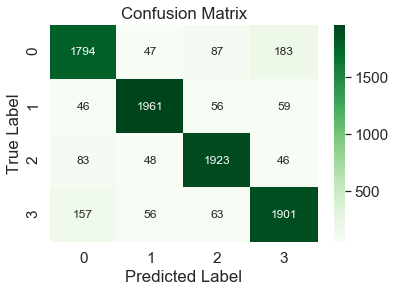

In [42]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(4), range(4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [43]:
nbAcc = metrics.accuracy_score(y_test, y_pred)

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [45]:
logreg.fit(X_train_vec, y_train)

/Users/mufidharahap/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
y_pred_logreg = logreg.predict(X_test_vec)

In [47]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test, y_pred_logreg))
print('=======================================================')

=================CLASSIFICATION REPORT=================


               precision    recall  f1-score   support

     Business       0.86      0.86      0.86      2111
Entertainment       0.90      0.94      0.92      2122
      Medical       0.92      0.90      0.91      2100
   Technology       0.89      0.87      0.88      2177

     accuracy                           0.89      8510
    macro avg       0.89      0.89      0.89      8510
 weighted avg       0.89      0.89      0.89      8510



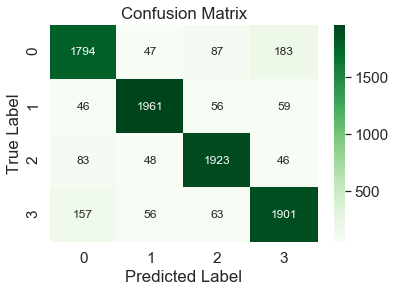

In [48]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(4), range(4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
lrAcc = metrics.accuracy_score(y_test, y_pred)

### Let's try Using other models using a Pipeline

#### First we need to redefine our text cleaner to it will return words and set is as the analyzer for our Bag of Words.

In [50]:
def text_cleaner_pipe(text):
    """
    1. Remove all non-words
    2. Transform the review in lower case
    3. Remove all stop words
    4. Perform stemming
    """
    
    text = re.sub("[^A-Za-z]", " ", text)
    text = text.lower()
    text = word_tokenize(text)
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
    return text

### Decision Tree

In [51]:
from sklearn.pipeline import Pipeline

In [52]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7fd8a78ef3b0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_

In [53]:
y_pred = pipe.predict(X_test)

In [54]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


               precision    recall  f1-score   support

     Business       0.71      0.79      0.75      2111
Entertainment       0.86      0.81      0.83      2122
      Medical       0.83      0.82      0.82      2100
   Technology       0.82      0.78      0.80      2177

     accuracy                           0.80      8510
    macro avg       0.80      0.80      0.80      8510
 weighted avg       0.80      0.80      0.80      8510



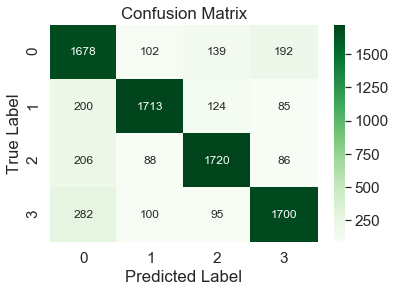

In [55]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(4), range(4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [56]:
dtAcc = metrics.accuracy_score(y_test, y_pred)

### Support Vector Machine

In [57]:
from sklearn.svm import SVC

pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', SVC(random_state=42, probability=True))])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7fd8a78ef3b0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                                 tokenizer=None, vocabulary=None)),
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, deci

In [58]:
y_pred = pipe.predict(X_test)

In [59]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


               precision    recall  f1-score   support

     Business       0.87      0.88      0.88      2111
Entertainment       0.93      0.95      0.94      2122
      Medical       0.94      0.92      0.93      2100
   Technology       0.91      0.90      0.90      2177

     accuracy                           0.91      8510
    macro avg       0.91      0.91      0.91      8510
 weighted avg       0.91      0.91      0.91      8510



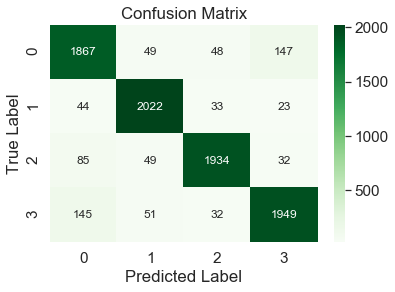

In [60]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(4), range(4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [61]:
svmAcc = metrics.accuracy_score(y_test, y_pred)

### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', RandomForestClassifier())])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7fd8a78ef3b0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.

In [63]:
y_pred = pipe.predict(X_test)

In [64]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


               precision    recall  f1-score   support

     Business       0.83      0.83      0.83      2111
Entertainment       0.81      0.91      0.86      2122
      Medical       0.88      0.86      0.87      2100
   Technology       0.89      0.81      0.85      2177

     accuracy                           0.85      8510
    macro avg       0.85      0.85      0.85      8510
 weighted avg       0.85      0.85      0.85      8510



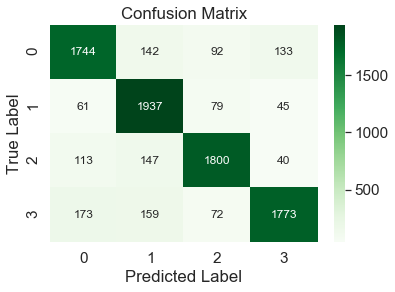

In [65]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(4), range(4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [66]:
rfAcc = metrics.accuracy_score(y_test, y_pred)

### Let's Make a Dataframe with the scores of each models

In [67]:
pd.DataFrame([['MultinomialNB',nbAcc], ['Logistic Regression',lrAcc], ['Decision Tree',dtAcc], ['SVM',svmAcc], ['Random Forest',rfAcc]], columns=['Model','Score']).sort_values('Score', ascending=False)

,Model,Score
3,SVM,0.913278
0,MultinomialNB,0.890599
1,Logistic Regression,0.890599
4,Random Forest,0.852409
2,Decision Tree,0.800353


#### From here we can conclude that the SVM model performs the best. We can then hypertune the model and let's see if we can still improve the performance.

### Hyperparameter Tuning SVC

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param = {'C': [1.0,1.5,2], 'degree': [3,5,7]}

grid_search = GridSearchCV(SVC(random_state=42), param, n_jobs=-1, cv=5)
grid_search.fit(X_test_vec, y_test)
print(grid_search.best_params_)

{'C': 2, 'degree': 3}


In [69]:
pipe = Pipeline([('bow', CountVectorizer(analyzer=text_cleaner_pipe)), 
                 ('tfid', TfidfTransformer()),  
                 ('model', SVC(C=1.5,degree=3, random_state=42, probability=True))])
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_cleaner_pipe at 0x7fd8a78ef3b0>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\...
                                 tokenizer=None, vocabulary=None)),
                ('tfid',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('model',
                 SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, deci

In [70]:
y_pred = pipe.predict(X_test)

In [71]:
print('=================CLASSIFICATION REPORT=================')
print('\n')
print(metrics.classification_report(y_test,y_pred))
print('=======================================================')

=================CLASSIFICATION REPORT=================


               precision    recall  f1-score   support

     Business       0.88      0.89      0.88      2111
Entertainment       0.94      0.95      0.94      2122
      Medical       0.94      0.92      0.93      2100
   Technology       0.91      0.90      0.90      2177

     accuracy                           0.92      8510
    macro avg       0.92      0.92      0.92      8510
 weighted avg       0.92      0.92      0.92      8510



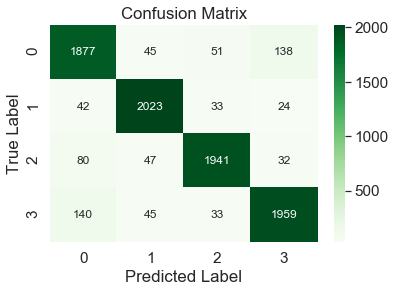

In [72]:
array = metrics.confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(array, range(4), range(4))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g',cmap="Greens").set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [80]:
svm2Acc = metrics.accuracy_score(y_test, y_pred)

In [81]:
pd.DataFrame([['SVM',svmAcc], ['Tuned SVM',svm2Acc]])

,0,1
0,SVM,0.913278
1,Tuned SVM,0.916569


### Now, we are going to make a simple function that returns the prediction and the probability of a new headline.

In [75]:
def predict(text):
    label = pipe.predict([text])
    prob = pipe.predict_proba([text])
    bPercent = int(prob[0][0]*100)
    ePercent = int(prob[0][1]*100)
    mPercent = int(prob[0][2]*100)
    tPercent = int(prob[0][3]*100)

    if label[0] == 'Business':
        return(f"Prediction: Business\nProbablity of {bPercent}%")
    elif label[0] == 'Entertainment':
        return(f"Prediction: Entertainment\nProbablity of {ePercent}%")
    elif label[0] == 'Medical':
        return(f"Prediction: Medical\nProbablity of {mPercent}%")
    else:
        return(f"Prediction: Technology\nProbablity of {tPercent}%")

In [76]:
bNews = 'Investment tax break for big business better for economy'

print(predict(bNews))

Prediction: Business
Probablity of 98%


In [77]:
eNews = "Box Office: Chris Nolan’s ‘Tenet’ Was The Right Movie At The Wrong Time"

print(predict(eNews))

Prediction: Entertainment
Probablity of 99%


In [78]:
mNews = 'New approach may give new life to old antibiotic'

print(predict(mNews))

Prediction: Medical
Probablity of 93%


In [79]:
tNews = "Robotic Interviews, Machine Learning And the Future Of Workforce Recruitment"

print(predict(tNews))

Prediction: Technology
Probablity of 72%
